In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
dir_path = '/home/liaoqing/program data/kaggle race/riiid-data/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [3]:
#nrows = 100 * 10000
nrows = None
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

In [4]:
questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                       }
                    )

In [5]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False
5,5,157063,115,156,0,5,1,5000.0,False
6,6,176092,115,51,0,6,1,17000.0,False
7,7,194190,115,50,0,7,1,17000.0,False
8,8,212463,115,7896,0,8,1,16000.0,False
9,9,230983,115,7863,0,9,1,16000.0,False


模型没法识别文本类型 先处理下'prior_question_had_explanation'

In [6]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)
#map 改为1，0 fillna为-1 设置类型 astype np.int8

目的是回答准确率那听课的就不要了 （——之后自己处理时在讨论现在先不要了）

In [7]:
train = train[train['content_type_id']==0]

接下来看一下简单内存回收的问题 

In [8]:
a = train.copy()#创建后内存增加 
del a #删除了a但内存没释放

In [9]:
import gc
gc.collect()

40

压缩数据

In [10]:
max_num = 100
train['user_id'].value_counts().reset_index()
train = train.groupby(['user_id']).tail(max_num)#取每个user最后100行的数据减小内存

合并数据 
需要用到pd.merge函数 很好的讲解:https://blog.csdn.net/weixin_37226516/article/details/64137043
merge的参数
on：列名，join用来对齐的那一列的名字，用到这个参数的时候一定要保证左表和右表用来对齐的那一列都有相同的列名。

left_on：左表对齐的列，可以是列名，也可以是和dataframe同样长度的arrays。

right_on：右表对齐的列，可以是列名，也可以是和dataframe同样长度的arrays。

left_index/ right_index: 如果是True的haunted以index作为对齐的key

how：数据融合的方法。 left 就是保留左表全部的数据 左有右面没有那合并后右面是nan，如果右面有左面没有那右面删除不要了

sort：根据dataframe合并的keys按字典顺序排序，默认是，如果置false可以提高表现。

In [11]:
train = pd.merge(left=train,
                 right=questions,
                 how='left',
                 left_on='content_id',
                 right_on='question_id'
                 )#左面训练数据右问题数据，左面全保留 左侧的con——id和右侧的ques_id对应合并

In [12]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part
0,0,0,115,5692,0,1,1,NaN,-1,5692,5692,5
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1
5,5,157063,115,156,0,5,1,5000.0,0,156,156,1
6,6,176092,115,51,0,6,1,17000.0,0,51,51,1
7,7,194190,115,50,0,7,1,17000.0,0,50,50,1
8,8,212463,115,7896,0,8,1,16000.0,0,7896,7896,1
9,9,230983,115,7863,0,9,1,16000.0,0,7863,7863,1


In [13]:
train = train.fillna(0)

处理类别特征 首先需要对特征进行编码 nan是0了编码从1开始 one hot太稀疏费内存类别多的话
若某一列[‘男’,'女','男','男','中'] -->先fit -->{‘男’：1，‘女’：2，‘中’:3}得到这么一个字典
-->tranform--> [1,2,1,1,3]

In [14]:
class cat_deal:
    def __init__(self):
        self.max_len = 0#不同个数 0是nan嘛所以从1开始算
        self.dict_map = {}
    
    def fit(self,cat_list):
        index = 1
        for cat_i in cat_list:
            if cat_i not in self.dict_map:
                self.dict_map[cat_i]  = index
                index += 1
        self.max_len = index + 1#保险一点怕有异常值
    
    def transform (self,cat_list):
        cat_transform_list = []
        for cat_i in cat_list:
            if cat_i in self.dict_map:
                cat_transform_list.append(self.dict_map[cat_i])
            else:
                cat_transform_list.append(0)
        return cat_transform_list

处理浮点特征 用最大最小值做一个归一化

In [15]:
class float_deal:
    def __init__(self):
        self.min = 0
        self.max = 0
        self.max_min = 0
    
    def fit(self,float_list):
        for float_i in float_list:
            if float_i < self.min:
                self.min = float_i
            if float_i > self.max:
                self.max = float_i
        self.max_min = self.max - self.min
    
    def transform(self,float_list):
        float_transform_list = []
        for float_i in float_list:
            if float_i < self.min:
                float_transform_list.append(0)
            elif float_i > self.max:
                float_transform_list.append(1)
            else:
                float_transform_list.append(float_i/self.max_min)
        return float_transform_list

处理类别特征数据

In [16]:
train.head(10)#处理前

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part
0,0,0,115,5692,0,1,1,0.0,-1,5692,5692,5
1,1,56943,115,5716,0,2,1,37000.0,0,5716,5716,5
2,2,118363,115,128,0,0,1,55000.0,0,128,128,1
3,3,131167,115,7860,0,3,1,19000.0,0,7860,7860,1
4,4,137965,115,7922,0,4,1,11000.0,0,7922,7922,1
5,5,157063,115,156,0,5,1,5000.0,0,156,156,1
6,6,176092,115,51,0,6,1,17000.0,0,51,51,1
7,7,194190,115,50,0,7,1,17000.0,0,50,50,1
8,8,212463,115,7896,0,8,1,16000.0,0,7896,7896,1
9,9,230983,115,7863,0,9,1,16000.0,0,7863,7863,1


In [17]:
dict_cat_class = {}
for columns in ['user_id','content_id',\
                'task_container_id','prior_question_had_explanation',\
                'bundle_id','part']:
    dict_cat_class[columns] = cat_deal()
    dict_cat_class[columns].fit(train[columns])
    
    train[columns] = dict_cat_class[columns].transform(train[columns])
    print(columns)

user_id
content_id
task_container_id
prior_question_had_explanation
bundle_id
part


In [18]:
print(dict_cat_class['part'].dict_map)
print(dict_cat_class['part'].max_len)

{5: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7}
9


浮点特征处理

In [19]:
dict_float_class = {}
for columns in ['timestamp','prior_question_elapsed_time']:
    dict_float_class[columns] = float_deal()
    dict_float_class[columns].fit(train[columns])
    
    train[columns] = dict_float_class[columns].transform(train[columns])
    print(columns)

timestamp
prior_question_elapsed_time


In [20]:
dict_float_class['prior_question_elapsed_time'].max

300000.0

In [21]:
dict_float_class['prior_question_elapsed_time'].min

0

<AxesSubplot:>

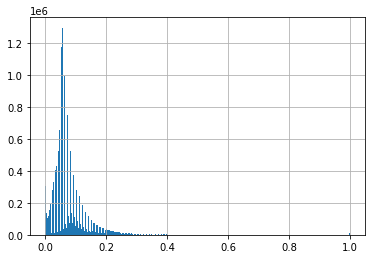

In [22]:
train['prior_question_elapsed_time'].hist(bins = 500)#看下分布 这样归一化样本分布部太平均的 0算是异常值吗这个要自己判断

In [23]:
train.head(10)#处理后 其实这样做破坏了原有数据之间存在的大小关系，这也是优点之一全变成index小 编码就小了跟其他的数据没关系了

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part
0,0,0.000000e+00,1,1,0,1,1,0.000000,1,5692,1,1
1,1,6.513297e-07,1,2,0,2,1,0.123333,2,5716,2,1
2,2,1.353869e-06,1,3,0,3,1,0.183333,2,128,3,2
3,3,1.500324e-06,1,4,0,4,1,0.063333,2,7860,4,2
4,4,1.578082e-06,1,5,0,5,1,0.036667,2,7922,5,2
5,5,1.796530e-06,1,6,0,6,1,0.016667,2,156,6,2
6,6,2.014189e-06,1,7,0,7,1,0.056667,2,51,7,2
7,7,2.221199e-06,1,8,0,8,1,0.056667,2,50,8,2
8,8,2.430210e-06,1,9,0,9,1,0.053333,2,7896,9,2
9,9,2.642047e-06,1,10,0,10,1,0.053333,2,7863,10,2


In [24]:
# train['prior_question_elapsed_time_0'] = train['prior_question_elapsed_time'].map(lambda x: 1 if x==0 else 0)
#可以新开一列来处理异常值 单拿出来也行 去除也行 

包装一些可能用到的函数 包装成lambda
 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
  tf.shape(tf.squeeze(t, [2, 4]))  # [1, 2, 3, 1]

In [25]:
def squeeze(embedding):#删除为1的维
    embedding = tf.squeeze(embedding,axis=1)
    return embedding
def concat(embedding_list):#沿第一维拼接张量
    embedding = tf.concat(embedding_list, axis=1)
    return embedding
def multiply(multi_x_y):#对应元素相乘
    multi_x = multi_x_y[0]
    multi_y = multi_x_y[1]
    multi_x_y = tf.multiply(multi_x, multi_y)
    return multi_x_y

数据输入 全做成tenser 一会要把每个特征都分别embedding到向量 所以分开写

In [26]:
input_timestamp = tf.keras.Input(shape=(1,))
input_prior_question_elapsed_time = tf.keras.Input(shape=(1,))

input_user = tf.keras.Input(shape=(1,))
input_content = tf.keras.Input(shape=(1,))
input_task_container = tf.keras.Input(shape=(1,))
input_prior_question_had_explanation = tf.keras.Input(shape=(1,))
input_bundle = tf.keras.Input(shape=(1,))
input_part = tf.keras.Input(shape=(1,))

In [27]:
inputs = [input_timestamp,input_prior_question_elapsed_time,\
         input_user,input_content,\
         input_task_container,input_prior_question_had_explanation,\
         input_bundle,input_part]

类别特征embeeding转换¶

In [28]:
#layers.Embedding?
# #layers.Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer='uniform',
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs,
#input_length: 输入序列的长度，当它是固定的时。 如果你需要连接 Flatten 和 Dense 层，则这个参数是必须的 （没有它，dense 层的输出尺寸就无法计算）。

In [29]:
embedding_user = tf.keras.layers.Embedding(dict_cat_class['user_id'].max_len,
                                           1, input_length=1)(input_user)
print("squeeze 前:",embedding_user.shape)
embedding_user = tf.keras.layers.Lambda(squeeze)(embedding_user)
print("squeeze 后:",embedding_user.shape)
#全部特征都做成1维稠密向量
#tf.keras.layers.Lambda 将任意表达式封装为 Layer 对象。
#再去掉多余维


embedding_content = tf.keras.layers.Embedding(dict_cat_class['content_id'].max_len,
                                              5, input_length=1)(input_content)
embedding_content = tf.keras.layers.Lambda(squeeze)(embedding_content)

embedding_task_container = tf.keras.layers.Embedding(dict_cat_class['task_container_id'].max_len,
                                                     5, input_length=1)(input_task_container)
embedding_task_container = tf.keras.layers.Lambda(squeeze)(embedding_task_container)

embedding_prior_question_had_explanation = tf.keras.layers.Embedding(dict_cat_class['prior_question_had_explanation'].max_len, 
                                                                     5, input_length=1)(input_prior_question_had_explanation)
embedding_prior_question_had_explanation = tf.keras.layers.Lambda(squeeze)(embedding_prior_question_had_explanation)

embedding_bundle = tf.keras.layers.Embedding(dict_cat_class['bundle_id'].max_len,
                                             5, input_length=1)(input_bundle)
embedding_bundle = tf.keras.layers.Lambda(squeeze)(embedding_bundle)

embedding_part = tf.keras.layers.Embedding(dict_cat_class['part'].max_len,
                                           5, input_length=1)(input_part)
embedding_part = tf.keras.layers.Lambda(squeeze)(embedding_part)

squeeze 前: (None, 1, 1)
squeeze 后: (None, 1)


合并类别特征对应的embeeding特征和浮点特征

In [30]:
embedding_all = [input_timestamp,input_prior_question_elapsed_time,\
                embedding_user, embedding_content, embedding_task_container,\
                embedding_prior_question_had_explanation, embedding_bundle, embedding_part]

lr_all = embedding_all + [input_timestamp,input_prior_question_elapsed_time]

In [31]:
lr_all#发现是很多个1维 需要把第一个维度上拼接一下

[<tf.Tensor 'input_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'lambda_1/Identity:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'lambda_2/Identity:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'lambda_3/Identity:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'lambda_4/Identity:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'lambda_5/Identity:0' shape=(None, 5) dtype=float32>,
 <tf.Tensor 'input_1:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, 1) dtype=float32>]

In [32]:
lr_layer = layers.Lambda(concat)(lr_all)
lr_layer#可看出在第一维度上拼接在一起了

<tf.Tensor 'lambda_6/Identity:0' shape=(None, 30) dtype=float32>

In [33]:
x = layers.Dense(10,activation= tf.nn.relu)(lr_layer)
logit = layers.Dense(1,activation= tf.nn.sigmoid)(x)

In [34]:
model = tf.keras.Model(inputs =inputs,outputs = logit )

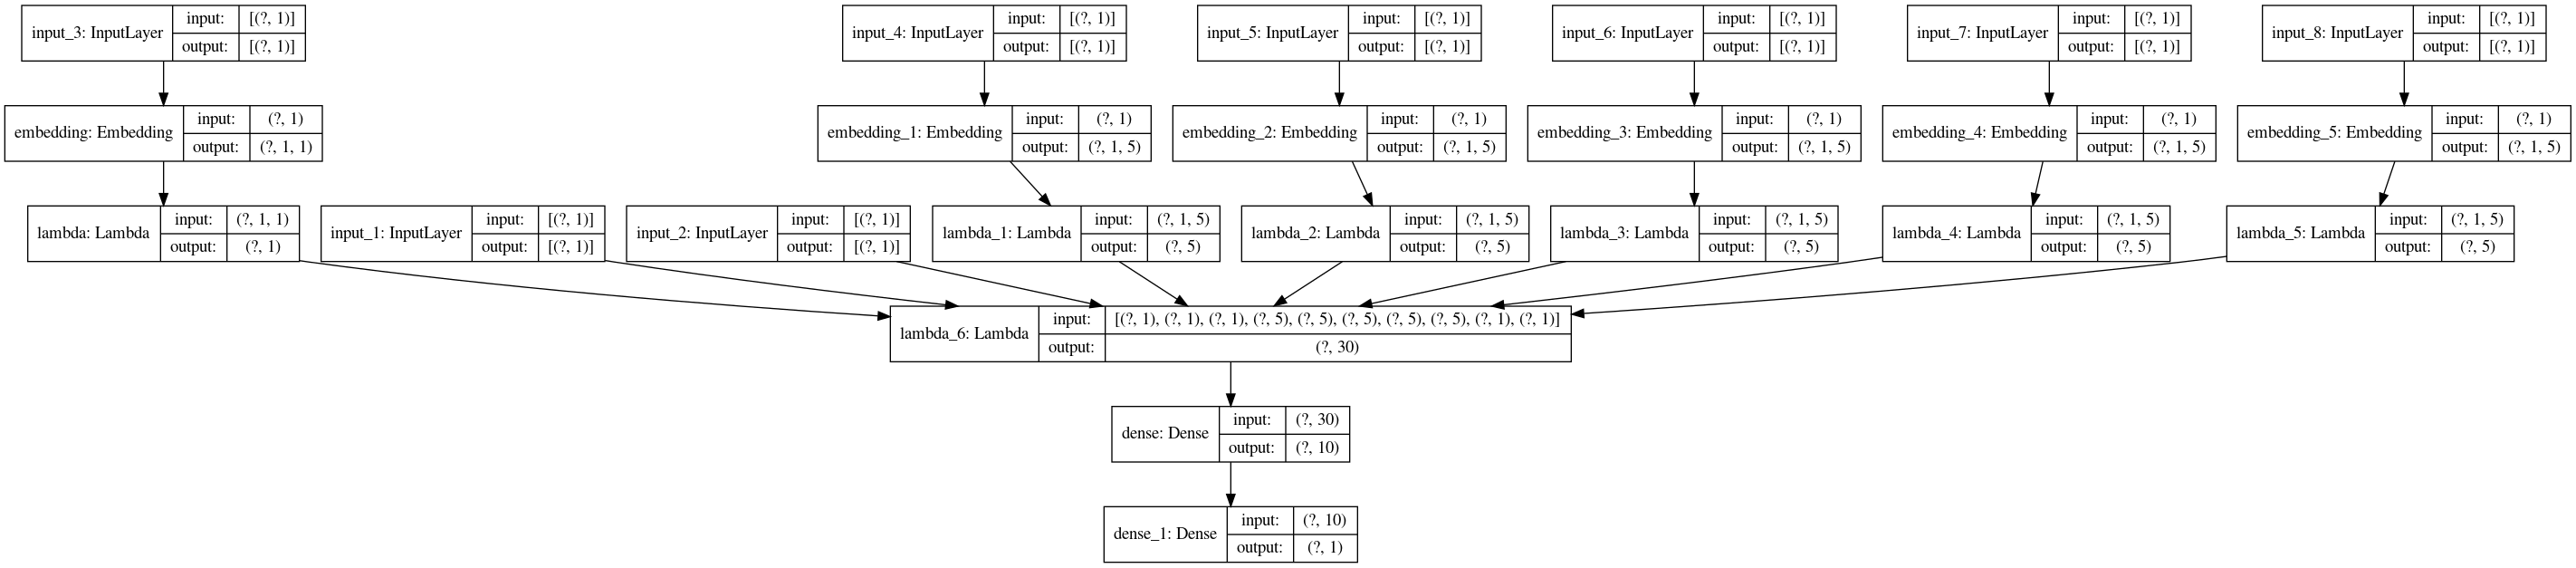

In [35]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [36]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_crossentropy'])

接下来需要设置三个 callback 分别是早停 学习率下降 checkpoint

In [37]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.1,
                                               patience=6,
                                               mode='min',
                                               verbose =1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 mode='min', 
                                                 patience=10,
                                                 verbose=1)

check_point = tf.keras.callbacks.ModelCheckpoint(filepath='fold_h5',
                                   monitor='val_loss',
                                   verbose=1, 
                                   mode = 'min', 
                                   save_best_only = True)

callbacks = [plateau,early_stopping,check_point]

模型和回调函数都写好了，接下来要 对数据train 进行处理 100个user的数据切分做标签
不记得操作可以看下面

In [38]:
# #首先看以下操作
# df = pd.DataFrame({
#     'brand': ['Yum Yum', 'Yum Yum', 'Indomie', 'Indomie', 'Indomie'],
#     'style': ['cup', 'cup', 'cup', 'pack', 'pack'],
#     'rating': [4, 4, 3.5, 15, 5]
# })
# print(df)
# last_records = df.drop_duplicates('brand',keep = 'last')#照brand重复的数据，保留最后一条其余不要
# print(last_records)
# dict(zip(last_records['brand'],last_records['style'])) #将两list或df两列的数据dict(zip()) 成为对应的字典

# #注意map apply applymap 区别 https://ai.deepshare.net/live/l_5f86a753e4b0e95a89c3fc7d
# #不论是利用字典还是函数进行映射，map方法都是把对应的数据逐个当作参数传入到字典或函数中，得到映射后的值。
# #data["gender"] = data["gender"].map({"男":1, "女":0}) map里是个字典的映射
# #apply方法，apply方法的作用原理和map方法类似，区别在于apply能够传入功能更为复杂的函数。

首先 训练和验证集的分法 我们要解决的问题 官网：
Your challenge in this competition is a version of that overall task; you will predict whether students are able to answer their next questions correctly. You'll be provided with the same sorts of information a complete education app would have: that student's historic performance, the performance of other students on the same question, metadata about the question itself, and more.
我们想知道这些A学生能否回答对S问题
我们知道A学生的历史表现 其他题目回答得怎么样 这些题目别的学生回答怎么样
知道S问题本身的信息 和其他学生对S问题的回答情况
那分法应当为 按用户id分，每个用户拿走一部分的问答情况来作为验证集，下一道题，那我们应从后往前拿，毕竟user成长了，
水平也提高了需要参考历史来对下题进行判断

看test——example那个数据 是接下来时间的各种 user 问题都可能出现

In [39]:
train.groupby(['user_id'])['row_id'].count().reset_index()#看一下处理前每个user数据 因为取了最后100个 所以不足100全取了，100以上的每个都留了100条数据 共3824人
#要注意这次没用全数据，可能有一些根本没几条数据，验证集分太多可能直接把这个user 在训练集里就没了

,user_id,row_id
0,1,46
1,2,30
2,3,19
3,4,100
4,5,100
...,...,...
393651,393652,100
393652,393653,100
393653,393654,50
393654,393655,100


In [40]:

valid = pd.DataFrame()
for i in range(10):
    last_records = train.drop_duplicates('user_id',keep='last')#取出每个user最后一条记录
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))#做一个取出的user到取出的记录的行索引的字典
    train['filter_row'] = train['user_id'].map(map__last_records__user_row)#每个user新添加一个该user被拿走的最后一条的row——id的记录
    train = train[train['row_id']<train['filter_row']]#对行保留没被拿走的作为训练集
    
    valid = valid.append(last_records)
    print(len(valid))
    


393656
787225
1180734
1574202
1967602
2360984
2754348
3146047
3537383
3928411


分完了 来做标签 分测试集

In [41]:
type(valid['user_id'].values)

numpy.ndarray

In [42]:

features_columns = ['timestamp','prior_question_elapsed_time',\
                    'user_id','content_id',\
                    'task_container_id','prior_question_had_explanation',\
                    'bundle_id','part']#这些是要训练的
X_valid, y_valid = [valid[columns].values for columns in features_columns], valid['answered_correctly'].values#怎么理解这一句
#这是for分别取出了每一列 然后放在一个list里【】 但每个列是ndarray
X_train, y_train = [train[columns].values for columns in features_columns], train['answered_correctly'].values

In [43]:
print(type(X_train))#.values方法拿出来的是ndarray
print(type(X_train[0]))
print(type(valid))
print(type(valid['row_id']))
print(X_train[0].shape)
print(y_train.shape)
print(X_valid[0].shape)

<class 'list'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(18150006,)
(18150006,)
(3928411,)


接下来训练模型

In [ ]:
model.fit(X_train,y_train,
          epochs= 100, 
          batch_size = 512*500*2,
          verbose= 1,
          shuffle=True,
          validation_data=(X_valid,y_valid), 
          callbacks = callbacks)

Train on 18150006 samples, validate on 3928411 samples
Epoch 1/100
17920000/18150006 [============================>.] - ETA: 0s - loss: 0.6847 - binary_crossentropy: 0.6847
Epoch 00001: val_loss improved from inf to 0.67556, saving model to fold_h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fold_h5/assets
18150006/18150006 [==============================] - 6s 0us/sample - loss: 0.6845 - binary_crossentropy: 0.6845 - val_loss: 0.6756 - val_binary_crossentropy: 0.6756
Epoch 2/100
17920000/18150006 [============================>.] - ETA: 0s - loss: 0.6519 - binary_crossentropy: 0.6519
Epoch 00002: val_loss improved from 0.67556 to 0.65196, saving model to fold_h5
INFO:tensorflow:Assets written to: fold_h5/assets
18150006/18150006 [==============================] - 4s 0us/sample - loss: 0.6517 - binary_crossentropy: 0.6517 - val_loss: 0.6520 - val_binary_crossentropy: 0.6520
Epoch 3/100
17920000/18150006 [===========

In [ ]:
y_valid_proba = model.predict(X_valid,verbose=0,batch_size = 512)
auc = roc_auc_score(y_valid,y_valid_proba)
print(auc)

以下用保存的模型 验证